# Assignment 1 

In [ ]:
import os
import numpy as np
import pandas as pd

import albumentations as A                       # a great library for image data augmentation and processing 
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,ConcatDataset,SubsetRandomSampler

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import KFold,StratifiedKFold

import glob

import cv2

## base params once moved to .py format these will be CL arguments
INPUT_DIR = '/Users/kseniadrokov/Documents/לימודים/הפסקתי לספור/סמסטר א/סדנה מעשית בלמידה עמוקה/Ass1/archive-2/'
num_folds = 5 #k-fold
epochs = 5
batch_size = 128 #batch of photos in every epochs
size = 64 #photo size
seed=2020 #control random
num_classes=196 #196 classification of cars



use_cuda = torch.has_cuda

if use_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

print('active device',device)
print('me')

## Part 1 - Present an exploratory data analysis of the dataset that you selected

For this assignment I chose to use the car dataset (https://www.kaggle.com/jessicali9530/stanford-cars-dataset).
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split, that means that the data is balanced. Classes are typically at the level of Make, Model, Year, ex. 2012 Tesla Model S or 2012 BMW M3 coupe.
The images in the train part and in the test part are in different sizes, so there is a need to preprocesse them. 

In [ ]:
#load train data
_train = glob.glob(INPUT_DIR + 'cars_train/cars_train' + '/*.jpg')
_train.sort()
_train[:5],_train[1000:1005]

In [ ]:
train_label = pd.read_csv(INPUT_DIR + "train_2.csv")
train_label[:5],train_label[1000:1005]

Lets look at some of the train csv data -  
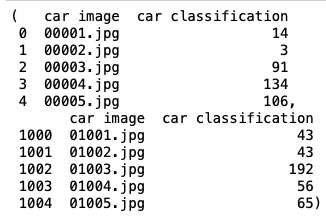

In [ ]:
_test = glob.glob(INPUT_DIR + 'cars_test/cars_test' + '/*.jpg')
_test.sort()
_test[:5],_test[1000:1005]

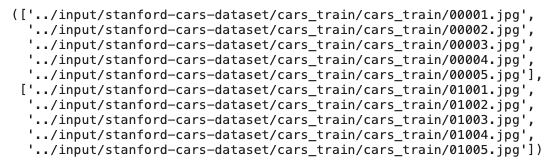

In [ ]:
!pip install mat4py

In [ ]:
#load classification
from mat4py import loadmat
classific = loadmat(INPUT_DIR + 'cars_annos.mat')
labels_list = classific.get('class_names')
for lables, numbers in enumerate(labels_list[:15]):
    print(lables,':',numbers)
print("\n total num of lables: " + str(len(labels_list)))

Lets look at some of the car classes -  
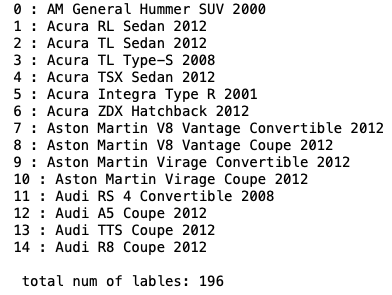

In [ ]:
import re
import matplotlib.pyplot as plt

In [ ]:
data_train = loadmat(INPUT_DIR + 'cars_train_annos.mat')
train_label_list = data_train.get('annotations').get('class')
image_id_list = data_train.get('annotations').get('fname')

In [ ]:
data_test = loadmat(INPUT_DIR + 'cars_test_annos_withlabels.mat')
test_label_list = data_test.get('annotations').get('class')  

In [ ]:
def display_image(car_class):
    %matplotlib inline
    fig, ax = plt.subplots(1,2,figsize=(15,7.5))
    plt.subplots_adjust(hspace=1)
    dot = '.'
    for i in range(2):
        label = labels_list[car_class[i]] #get the label of the car
        find_idx = train_label_list.index(car_class[i])
        find_dot = image_id_list[i].find(dot)
        int_id = image_id_list[i][0:find_dot] #take the number part
        car_image = cv2.imread(_train[find_idx]) #get the car that fits the label 
        car_image = cv2.cvtColor(car_image,cv2.COLOR_BGR2RGB) #fix colors
        car_image = cv2.resize(car_image,(size,size)) #resize image
        ax[i%2].imshow(car_image)
        ax[i%2].set_title(label)

Example of 2 cars that are easily separable:
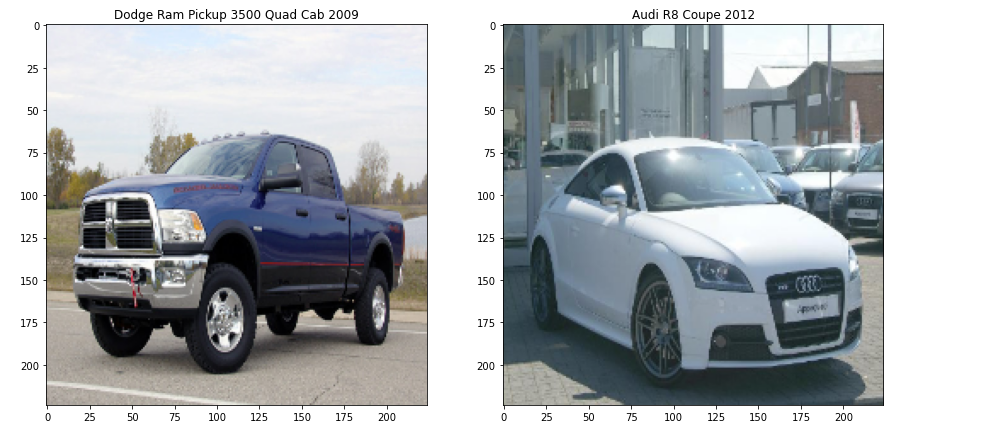

In [ ]:
display_image([86, 14])

Example of more similar cars:
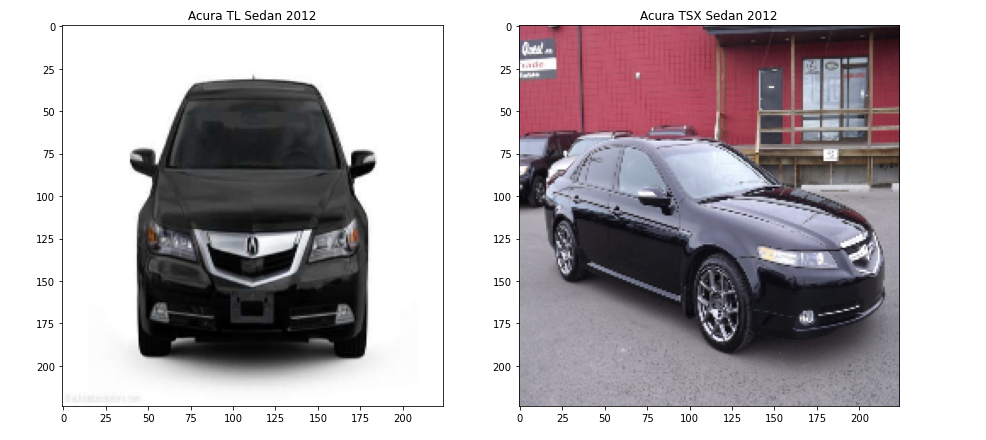

In [ ]:
display_image([2, 4])

In [ ]:
data_tuples = list(zip(_train,train_label_list))
data_tuples

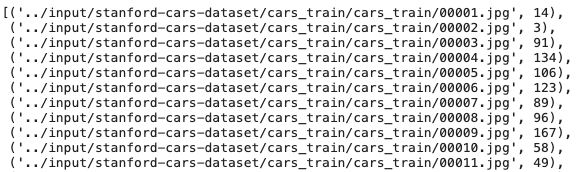

In [ ]:
transforms_train = A.Compose([A.Transpose(),A.Resize(height=size,width=size,p=1.0),A.Flip(),A.Normalize(),ToTensorV2(),])
transforms_valid = A.Compose([A.Resize(height=size,width=size,p=1.0),A.Normalize(),ToTensorV2()])

In [ ]:
df = pd.DataFrame(data_tuples, columns = ['image','car class'])
df.head()

train DataFrame - 
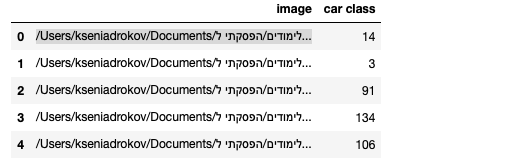

In [ ]:
test_data_tuples = list(zip(_test,test_label_list))
test_df = pd.DataFrame(test_data_tuples, columns = ['image','class'])
test_df

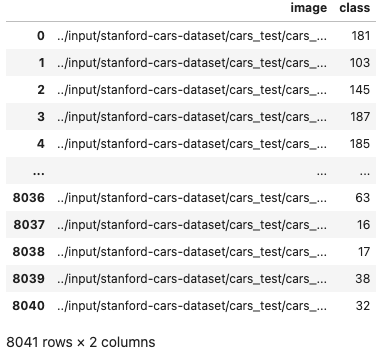

In [ ]:
class CarDataset(Dataset):
    def __init__(self,df,transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,idx):
        img_path = self.df.loc[idx]
        img = cv2.imread(img_path[0]) #get image from path
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype(np.float32) #fix colors
        label = img_path[1] -1
       # print('image path: ' + str(img_path[0]) + ' label: ' + str(label))
        if not self.transforms is None:
            transformed = self.transforms(image=img)
            img = transformed['image']
        return img,label

In [ ]:
train_set = CarDataset(df)
train_set

## part 2 - Form a neural network graph 

### First Model

In [ ]:
class CarModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.num_classes = num_classes # 196
        # in conv1 - 3x64x64
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5) 
        # in conv2 - 3x60x60
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5)
        # in conv3 - 3x56x56
        #self.conv3 = nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3)
        #self.pool = nn.MaxPool2d(kernel_size = 3) #Reduce tensor size
        self.fc1 = nn.Linear(12*56*56,5000)
        self.fc2 = nn.Linear(5000,num_classes)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(self.conv2(x))
       # x = self.relu(self.conv3(x))
       # x = self.pool(x)
        x = x.view(x.size(0), -1)
        #print('view')
        #print(x.view(x.size(0), 64*3*3).shape)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.relu(self.fc2(x))
       
        return x

In [ ]:
model = CarModel(num_classes).to(device)
model

In [ ]:
import time
def train_single_fold_second_version(fold,tr_loader,val_loader,model,criterion,optimizer):
    train_log = []
    start = time.time()
    for epoch in range(epochs):
     #   print('epoch {}'.format(epoch))
        model.train()
        tr_loss=0
        correct = 0
        total = 0
        for step, batch in enumerate(tr_loader):
            imgs, labels = batch
            imgs = imgs.to(device).float()
            labels = labels.to(device)

            outputs = model(imgs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            tr_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct/total
        
        model.eval()
        val_loss=0
        val_total = 0
        val_correct = 0
        val_preds = None
        val_labels = None
        true_labels = []
        
        for step, batch in enumerate(val_loader):
            imgs, labels = batch
            
            if val_labels is None:
                val_labels = labels.clone().squeeze(-1)
            else:
               # val_labels = torch.cat((val_labels, labels),dim=0)
                val_labels = torch.cat((val_labels, labels.squeeze(-1)),dim=0)
                
            imgs = imgs.to(device).float()
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(imgs)
               # print(outputs)
                
                loss = criterion(outputs,labels.squeeze(0))
                #loss = criterion(outputs,labels)
                val_loss+=loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
               # print('predicted:')
               # print(predicted)
                val_total += labels.size(0)
               # print('labels:')
               # print(labels)
                val_correct += (predicted == labels).sum().item()
                
                if val_preds is None:
                    val_preds = predicted
                else:
                    val_preds = torch.cat((val_preds,predicted),dim=0)
            true_labels.append(labels) #to compare with preds
        train_loss = tr_loss / len(tr_loader)
        validation_loss = val_loss / len(val_loader)
        #print('correct: ' + str(num_correct) + ' samples: ' + str(num_samples))
        val_acc = val_correct/val_total
        metrics = {
            'epoch':epoch,
            'train_loss':train_loss,
            'train_accuracy':train_acc,
            'validation_loss':validation_loss,
            'val_preds':val_preds,
            'val_accuracy':val_acc,
            'true_label': true_labels
            }
        train_log.append(metrics)
        print("Epoch:{}/{} Training Loss:{:.3f} Validation Loss:{:.3f} Validation Accuracy {:.2f} ".format(epoch + 1,
                                                                                                             epochs,
                                                                                                             train_loss,
                                                                                                             validation_loss,
                                                                                                             val_acc))
        print ("Total time: ", time.time() - start, "seconds")
    return val_preds, train_log

In [ ]:
learning_rate = 0.01 # added batch normaliztion
#batch_size = 224
def kfold_crossval_training_second_version(model):
    test_logs = []
    training_logs = []
    
    test_dataset = CarDataset(test_df, transforms=transforms_valid)
    test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    
    skf = StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=seed)
    for fold,(tr_ind,val_ind) in enumerate(skf.split(df.iloc[:,:1].values,df.iloc[:,1].values)):
        
        print('start training fold {}'.format(fold))
        
        train_df = df.iloc[tr_ind].reset_index(drop=True)
        val_df = df.iloc[val_ind].reset_index(drop=True)
        
        tr_dataset = CarDataset(train_df, transforms=transforms_train)
        val_dataset = CarDataset(val_df, transforms=transforms_valid)

        tr_loader = DataLoader(tr_dataset,batch_size=batch_size,shuffle=True)
        val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
        
        criterion = nn.CrossEntropyLoss() #DenseCrossEntropy()
        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
        
        val_preds, train_log = train_single_fold_second_version(fold,tr_loader,val_loader,model,criterion,optimizer)
        training_logs.append(train_log)

        #perform prediction on test data
        model.eval()
        test_preds = None
        total = 0
        correct = 0 
        true_labels = []
        
        for step,batch in enumerate(test_loader):
            imgs,labels = batch
            imgs = imgs.to(device).float()
            
            with torch.no_grad():
                outputs = model(imgs)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

       
                if test_preds is None:
                    test_preds = predicted
                else:
                    test_preds = torch.cat((test_preds,predicted),dim=0)
                
            true_labels.append(labels)
        test_acc = correct/total
        metrics = {
            'test_preds':test_preds,
            'test_accuracy':test_acc,
            'true-labels':labels
                }
        test_logs.append(metrics)
        
    return test_logs,training_logs

In [ ]:
 test_df.iloc[:2]

In [ ]:
tests_logs,training_logs = kfold_crossval_training_second_version(model)

training_logs - 
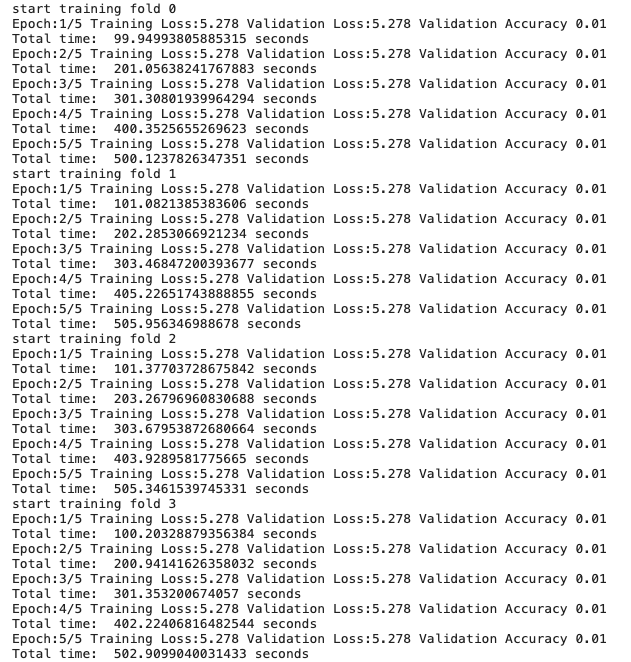

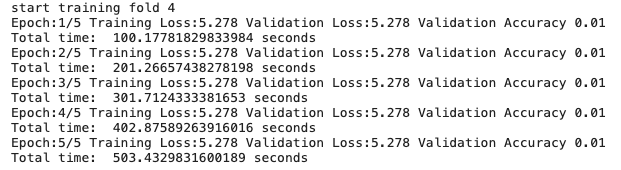

Let's look at the train loss vs validation loss of the first model: 

In [ ]:
train_loss_list = []
val_loss_list = []
for i in range(5):
    for j in range(5):
        train_loss_list.append(training_logs[i][j]['train_loss']) 
        val_loss_list.append(training_logs[i][j]['validation_loss'])
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

graph 1:

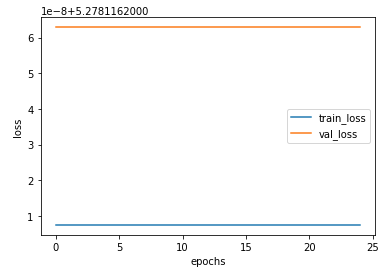

In [ ]:
train_acc_list = []
val_acc_list = []
test_acc_list = []
for i in range(0, 5):
    train_acc_list.append(training_logs[i][4]['train_accuracy']) 
    val_acc_list.append(training_logs[i][4]['val_accuracy'])
    test_acc_list.append(tests_logs[i]['test_accuracy'])
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.plot(test_acc_list, label = 'test_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

graph 2 - 
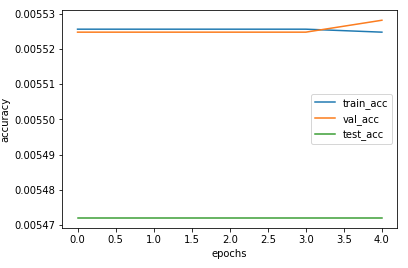

We can see that from the start to the end the model did not improve at all.
I can assume that reducing the image size can impair the learning of the model.
Another things is the model is very small, only 2 conv layers and 2 fc layers, maybe the model could get better if it had more layers and a Batch Normalization layer and changing conv parameters such as kernel size and stride.  

In [ ]:
size = 112
size

### Second Model

In [ ]:
class CarModelSecondVersion(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.num_classes = num_classes # 196
        # in conv1 - 3x112x112
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5) 
        self.conv1_bn=nn.BatchNorm2d(16)
        # in conv2 - 3x108x108
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, stride =2, kernel_size = 4)
        self.conv2_bn=nn.BatchNorm2d(32)
        # in conv3 - 3x53x53
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.conv3_bn=nn.BatchNorm2d(64)
        self.dropout1=nn.Dropout(0.25)
        # in fc1 - 3x51x51
        self.fc1 = nn.Linear(64*51*51,500)
        self.dropout2=nn.Dropout(0.25)
        self.fc2 = nn.Linear(500,num_classes)
        self.fc1_bn=nn.BatchNorm1d(num_classes)
        self.relu = nn.ReLU()
       
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
    
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
    
        x = self.dropout1(x)
    
        x = torch.flatten(x,1)
    
        x = self.fc1(x)
        
        x = self.dropout2(x)
    
        x = self.fc2(x)
        x = F.relu(self.fc1_bn(x))
       
        return x

In [ ]:
model2 = CarModelSecondVersion(num_classes).to(device)
model2

In [ ]:
transforms_train = A.Compose([
    A.Resize(width=size,height=size,p=1.0),
    A.Flip(),
    A.ShiftScaleRotate(rotate_limit=1.0,p=0.8),                            # rotate at any angle with 80% probability to be used
    A.OneOf([A.Emboss(p=1.0),A.Sharpen(p=1.0),A.Blur(p=1.0)],p=0.7),       # either emboss or sharpen or blur 
    A.Normalize(),                        # normalize
    ToTensorV2(),                         # shift channels to be first rather than last and convert to torch tensor
])

transforms_valid = A.Compose([
    A.Resize(width=size,height=size,p=1.0),
    A.Normalize(),
    ToTensorV2()    
])

In [ ]:
tests_logs2,training_logs2 = kfold_crossval_training_second_version(model2)

training logs -
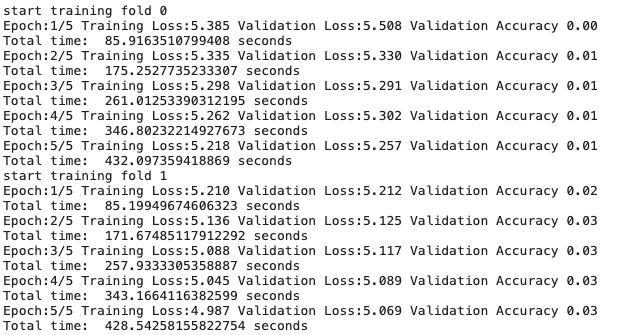

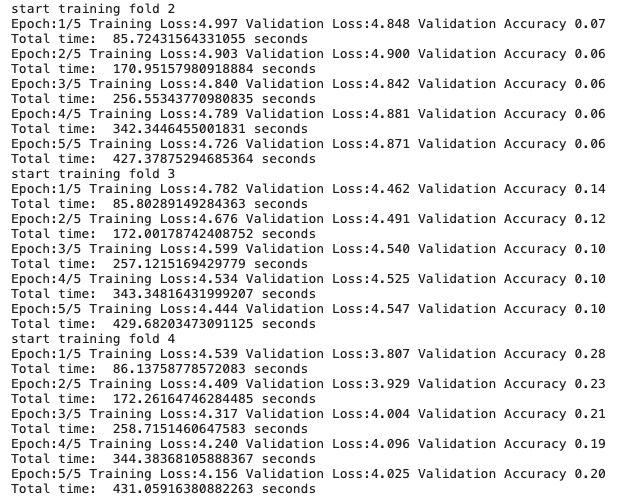

In [ ]:
#save results 
torch.save(model2, './model2.pth')
torch.save(tests_logs2, './model2_test.pt')
torch.save(training_logs2, './model2_train.pt')

In [ ]:
training_logs2

In [ ]:
training_logs2[1][1]

In [ ]:
tests_logs2

Let's look at the train loss vs validation loss of the second model: 

In [ ]:
train_loss_list = []
val_loss_list = []
for i in range(0, 5):
    for j in range(0, 5):
        train_loss_list.append(training_logs2[i][j]['train_loss']) 
        val_loss_list.append(training_logs2[i][j]['validation_loss'])
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

graph 3 -
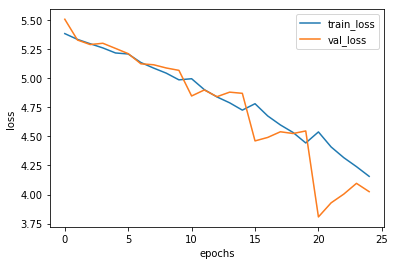

Now let's look at the train, validation & test accuracy of the second model:

In [ ]:
train_acc_list = []
val_acc_list = []
test_acc_list = []
for i in range(0, 5):
    train_acc_list.append(training_logs2[i][4]['train_accuracy']) 
    val_acc_list.append(training_logs2[i][4]['val_accuracy'])
    test_acc_list.append(tests_logs2[i]['test_accuracy'])
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.plot(test_acc_list, label = 'test_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

graph 4 -
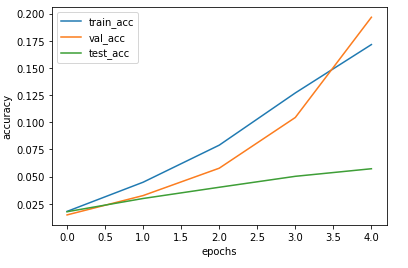

In [ ]:
training_logs2[1][1]['val_preds']

In [ ]:
torch.max(training_logs2[1][1]['true_label'][0])

In [ ]:
training_logs2[1][1]['true_label'][0][1]

In [ ]:
a = [0] * num_classes
for i in range(5):
    for j in range(5):
        num_of_elements = len(training_logs2[i][j]['true_label'][0])
        for h in range(num_of_elements):
            idx = training_logs2[i][j]['true_label'][0][h]
            if idx == training_logs2[i][j]['val_preds'][h]:
                a[idx] += 1

In [ ]:
b = [0] * num_classes
for i in range(num_classes):
    b[i] = str(i)

In [ ]:
plt.figure(figsize=(25,5))
plt.xlabel("Car Class")
plt.bar(b, a)
plt.xticks(rotation=90)
plt.show()

prediction of car images that were the right class label:

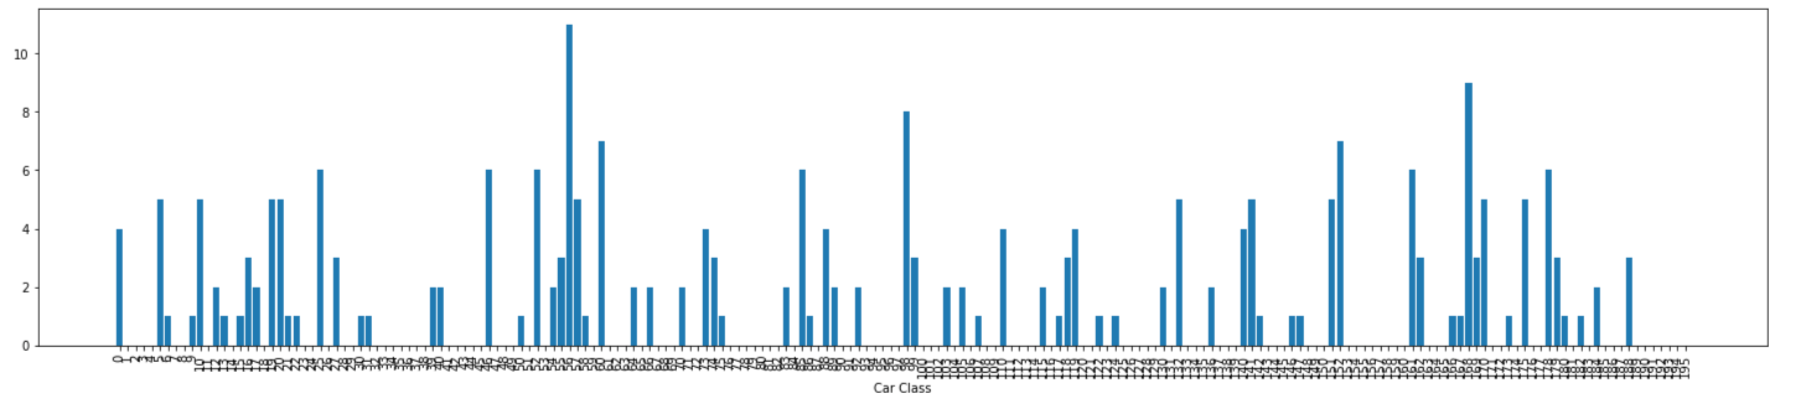

In [ ]:
max_idx = a.index(max(a))
max_idx

In [ ]:
min_idx = a.index(min(a))
min_idx

In [ ]:
display_image([152,148])

On the right is the car that was most detected than the others cars and on the left is the car that was least detected by the model: 


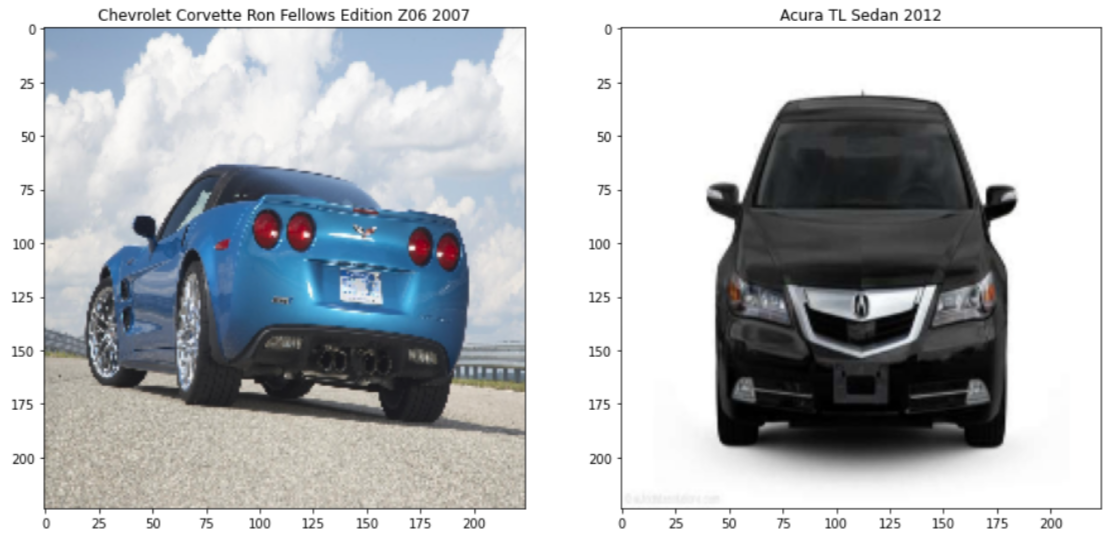

It can be seen that the second model was able to achieve better results than the first model.
The results of the test were still low compared to the results of the train and validation.
I'ts seems that the model was overfitted. 
As I suspected the 'Acura TL Sedan 2012' was a hard class to detcted (did not get detected at all), we can see from the previous graph that class 'Acura TSX Sedan 2012' was also not detected.

## part 3 - Use a pretrained model

In [ ]:
class model_version_3(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = torchvision.models.vgg16(pretrained=True)
        for param in self.backbone.parameters():
             param.requires_grad = False
        self.backbone.classifier[6] = nn.Linear(self.backbone.classifier[6].in_features,num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [ ]:
size = 224

In [ ]:
model3 = model_version_3(num_classes).to(device)
model3

In [ ]:
transforms_train = A.Compose([A.Transpose(),A.Resize(height=size,width=size,p=1.0),A.Flip(),A.Normalize(),ToTensorV2()])

In [ ]:
tests_logs3,training_logs3 = kfold_crossval_training_second_version(model3)

training logs - 
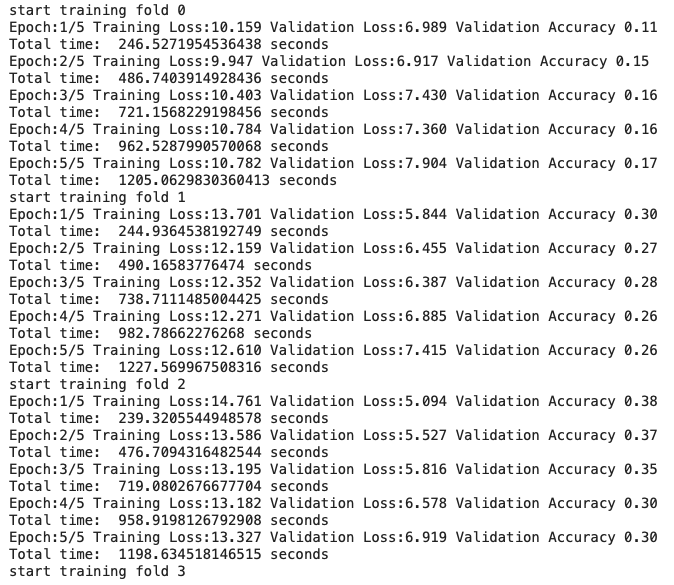

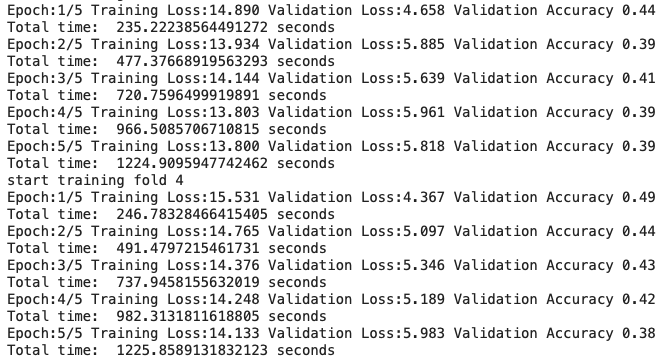

In [ ]:
#save results 
torch.save(model3, './model3.pth')
torch.save(tests_logs3, './model3_test.pt')
torch.save(training_logs3, './model3_train.pt')

In [ ]:
tests_logs3

In [ ]:
train_loss_list = []
val_loss_list = []
for i in range(0, 5):
    for j in range(0, 5):
        train_loss_list.append(training_logs3[i][j]['train_loss']) 
        val_loss_list.append(training_logs3[i][j]['validation_loss'])
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

graph 5 -
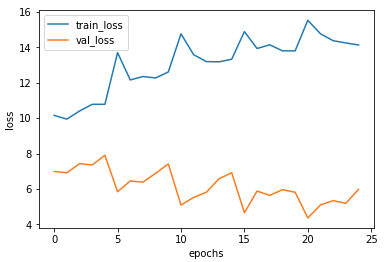

In [ ]:
train_acc_list = []
val_acc_list = []
test_acc_list = []
for i in range(0, 5):
    train_acc_list.append(training_logs3[i][4]['train_accuracy']) 
    val_acc_list.append(training_logs3[i][4]['val_accuracy'])
    test_acc_list.append(tests_logs3[i]['test_accuracy'])
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.plot(test_acc_list, label = 'test_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

graph 6 -
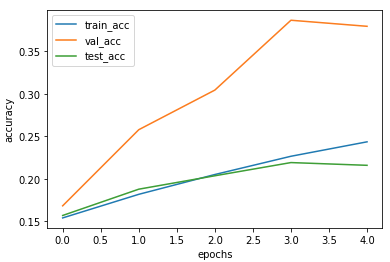

This model got better results then the previous 2 models but the test accuracy is still low.
I will try to add another linear layer at the end because the last layer has 4096 in features that connect to 196 nodes, add another drop layer and increase the number of epochs. 

In [ ]:
class model_version_4(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = torchvision.models.vgg16(pretrained=True)
        for param in self.backbone.parameters():
             param.requires_grad = False
        self.backbone.classifier[6] = nn.Linear(self.backbone.classifier[6].in_features,1500)
        self.fc2 = nn.Linear(1500,self.num_classes)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
model4 = model_version_4(num_classes).to(device)
model4

In [ ]:
tests_logs4, training_logs4 = kfold_crossval_training_second_version(model4)

training logs -
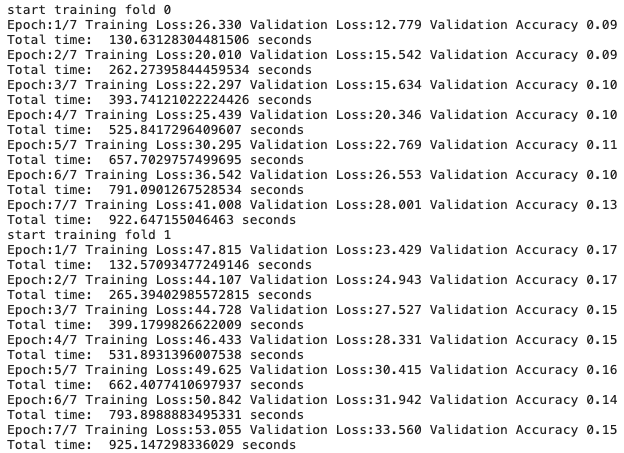

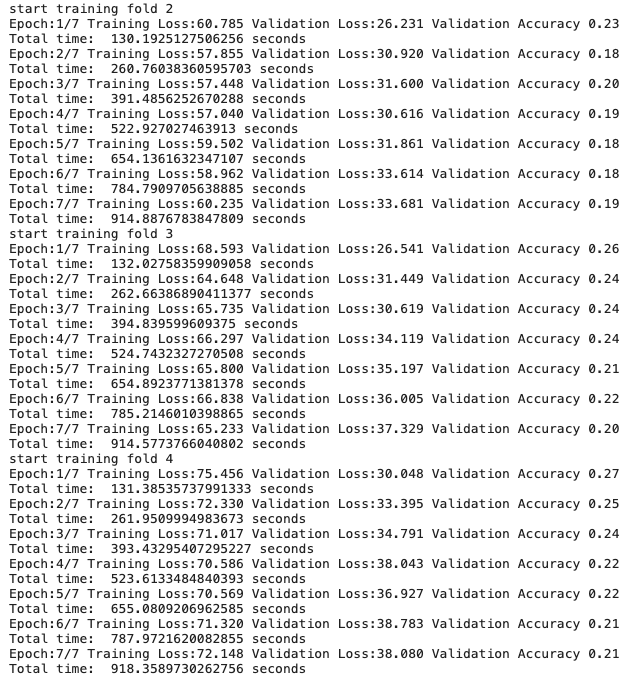

At first it seems like the model is trying to fight an overfit problem, but as the folds contiue it looks like the model is diverging, so i'm not sure if it was able to classify cars to the right class. 

In [ ]:
train_loss_list = []
val_loss_list = []
for i in range(0, 5):
    for j in range(0, 5):
        train_loss_list.append(training_logs4[i][j]['train_loss']) 
        val_loss_list.append(training_logs4[i][j]['validation_loss'])
plt.plot(train_loss_list,label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

graph 7 -
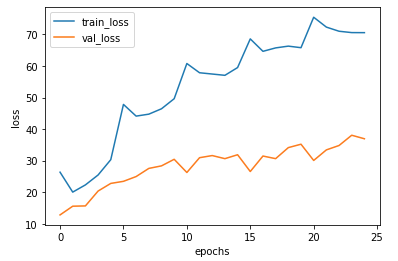

In [ ]:
train_acc_list = []
val_acc_list = []
test_acc_list = []
for i in range(0, 5):
    train_acc_list.append(training_logs4[i][4]['train_accuracy']) 
    val_acc_list.append(training_logs4[i][4]['val_accuracy'])
    test_acc_list.append(tests_logs4[i]['test_accuracy'])
plt.plot(train_acc_list,label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.plot(test_acc_list, label = 'test_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

graph 8 - 
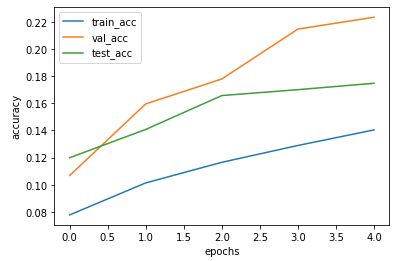

In [ ]:
a = [0] * num_classes
for i in range(5):
    for j in range(5):
        num_of_elements = len(training_logs4[i][j]['true_label'][0])
        for h in range(num_of_elements):
            idx = training_logs4[i][j]['true_label'][0][h]
            if idx == training_logs4[i][j]['val_preds'][h]:
                a[idx] += 1

In [ ]:
b = [0] * num_classes
for i in range(num_classes):
    b[i] = str(i)

In [ ]:
plt.figure(figsize=(25,5))
plt.xlabel("Car Class")
plt.bar(b, a)
plt.xticks(rotation=90)
plt.show()

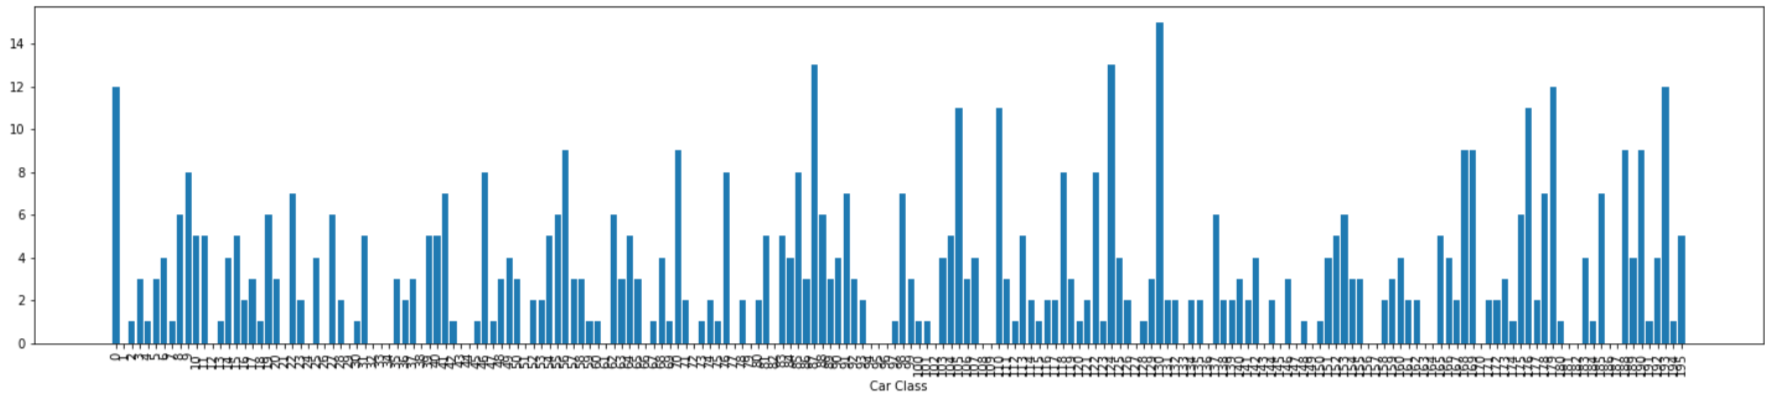

In [ ]:
!pip install prettytable 

In [6]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Model", "Epoch Run Time", "Total time", "Layers", "Image size"]) 
  
# Add rows 
myTable.add_row(["1", "8 minutes", "40 minutes", "4", "64x64"]) 
myTable.add_row(["2", "7 minutes", "35 minutes", "5", "112x112"]) 
myTable.add_row(["3", "20 minutes", "1 Hour", "16", "224x224"]) 
myTable.add_row(["4", "15 minutes","1.75 Hour", "17", "224x224"]) 
  
print(myTable)

myTable3 = PrettyTable(["Model", "Max Train Loss", "Min Train Loss", "Max Val Loss", "Min Val Loss"]) 
  
# Add rows 
myTable3.add_row(["1", "5.278", "5.278", "5.278", "5.278"]) 
myTable3.add_row(["2", "5.385", "4.156", "5.508", "3.807"]) 
myTable3.add_row(["3", "15.531", "10.159", "7.904", "4.367"]) 
myTable3.add_row(["4", "75.456", "20.010", "38.783", "12.779"]) 
  
print(myTable3)

myTable2 = PrettyTable(["Model", "Max Train Acc", "Min Train Acc", "Max Val Acc",
                       "Min Val Acc", "Max Test Acc", "Min Test Acc"]) 
  
# Add rows 
myTable2.add_row(["1", "0.55%", "0.55%", "1%", "1%", "0.54%", "0.54%"]) 
myTable2.add_row(["2", "17%", "0%", "28%",
                       "0%", "6%", "1%"]) 
myTable2.add_row(["3", "24%", "4%", "49%",
                       "11%", "30%", "15%"]) 
myTable2.add_row(["4", "14%", "2%", "27%",
                       "9%", "17%", "12%"]) 
  
print(myTable2)

+-------+----------------+------------+--------+------------+
| Model | Epoch Run Time | Total time | Layers | Image size |
+-------+----------------+------------+--------+------------+
|   1   |   8 minutes    | 40 minutes |   4    |   64x64    |
|   2   |   7 minutes    | 35 minutes |   5    |  112x112   |
|   3   |   20 minutes   |   1 Hour   |   16   |  224x224   |
|   4   |   15 minutes   | 1.75 Hour  |   17   |  224x224   |
+-------+----------------+------------+--------+------------+
+-------+----------------+----------------+--------------+--------------+
| Model | Max Train Loss | Min Train Loss | Max Val Loss | Min Val Loss |
+-------+----------------+----------------+--------------+--------------+
|   1   |     5.278      |     5.278      |    5.278     |    5.278     |
|   2   |     5.385      |     4.156      |    5.508     |    3.807     |
|   3   |     15.531     |     10.159     |    7.904     |    4.367     |
|   4   |     75.456     |     20.010     |    38.783    |  

In total the the assignment was interesting, it was the first time I made a NN so it was not easy.
It was nice to build my own network and to used an exsiting one and to see the difference in the results. 